In [1]:
import polars as pl
import pandas as pd
import json
from pathlib import Path

In [2]:
with open('movie_list.json', 'r') as f:
    movie_details = json.load(f)

In [3]:
movie_details

[{'file_name': '2_guns', 'title': '2 Guns', 'category': 'Action'},
 {'file_name': '300', 'title': '300', 'category': 'Action'},
 {'file_name': '47_ronin', 'title': '47 Ronin', 'category': 'Action'},
 {'file_name': '9', 'title': '9', 'category': 'Animation'},
 {'file_name': 'airplane', 'title': 'Airplane!', 'category': 'Comedy'},
 {'file_name': 'amazing_spider-man_the',
  'title': 'The Amazing Spider-Man',
  'category': 'Action'},
 {'file_name': 'avengers_age_of_ultron',
  'title': 'Avengers: Age of Ultron',
  'category': 'Action'},
 {'file_name': 'big_hero_6', 'title': 'Big Hero 6', 'category': 'Animation'},
 {'file_name': 'black_mass', 'title': 'Black Mass', 'category': 'Crime'},
 {'file_name': 'blackkklansman',
  'title': 'BlacKkKlansman',
  'category': 'Crime'},
 {'file_name': 'boondock_saints',
  'title': 'The Boondock Saints',
  'category': 'Crime'},
 {'file_name': 'chronicles_of_riddick',
  'title': 'The Chronicles of Riddick',
  'category': 'Sci-Fi'},
 {'file_name': 'dark_knight

In [4]:
raf = pl.read_parquet('../../evaluation/pixa_v3/movie_emotion_summary.parquet')

In [5]:
raf.head()

movie,count_happy,count_sad,count_angry,count_surprise,count_fear,avg_conf_happy,avg_conf_sad,avg_conf_angry,avg_conf_surprise,avg_conf_fear,avg_rel_face_area_happy,avg_rel_face_area_sad,avg_rel_face_area_angry,avg_rel_face_area_surprise,avg_rel_face_area_fear,total_faces,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,max_pct,dominant_emotion
str,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,str
"""i_am_legend""",251,286,64,17,72,0.809273,0.803297,0.753855,0.812256,0.76736,0.150848,0.207715,0.304145,0.109444,0.154558,690,9.275362,10.434783,36.376812,41.449275,2.463768,41.449275,"""sad"""
"""dark_knight_rises""",389,375,32,30,252,0.81142,0.800635,0.654449,0.70231,0.770434,0.079215,0.082949,0.116203,0.086569,0.102429,1078,2.96846,23.376623,36.085343,34.786642,2.782931,36.085343,"""happy"""
"""hp4_goblet_of_fire""",187,442,21,32,260,0.830018,0.844892,0.697174,0.714055,0.825253,0.10168,0.091217,0.108588,0.107552,0.118078,942,2.229299,27.600849,19.85138,46.921444,3.397028,46.921444,"""sad"""
"""pulp_fiction""",413,434,78,36,155,0.827257,0.810316,0.666207,0.712945,0.755984,0.097727,0.095182,0.133631,0.143398,0.108764,1116,6.989247,13.888889,37.007168,38.888889,3.225806,38.888889,"""sad"""
"""boondock_saints""",290,226,43,35,193,0.805676,0.753082,0.622813,0.676088,0.749732,0.079823,0.088596,0.100713,0.107472,0.088682,787,5.463787,24.523507,36.848793,28.716645,4.447268,36.848793,"""happy"""


In [6]:
raf.columns

['movie',
 'count_happy',
 'count_sad',
 'count_angry',
 'count_surprise',
 'count_fear',
 'avg_conf_happy',
 'avg_conf_sad',
 'avg_conf_angry',
 'avg_conf_surprise',
 'avg_conf_fear',
 'avg_rel_face_area_happy',
 'avg_rel_face_area_sad',
 'avg_rel_face_area_angry',
 'avg_rel_face_area_surprise',
 'avg_rel_face_area_fear',
 'total_faces',
 'angry_pct',
 'fear_pct',
 'happy_pct',
 'sad_pct',
 'surprise_pct',
 'max_pct',
 'dominant_emotion']

In [7]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

# -----------------------------
# Load parquet files
# -----------------------------

raf = pl.read_parquet("../../evaluation/raf/movie_emotion_summary.parquet")
best = pl.read_parquet("../../evaluation/pexpix_v1/movie_emotion_summary.parquet")

raf = raf.with_columns(pl.lit("raf").alias("model"))
best = best.with_columns(pl.lit("best").alias("model"))
best = best[raf.columns]

df = pl.concat([raf, best])

# -----------------------------
# Keep only needed columns
# -----------------------------

emotion_cols = [
    "angry_pct", "fear_pct", "happy_pct",
    "sad_pct", "surprise_pct"
]

df = df.select(
    ["movie", "model"] + emotion_cols
)

# -----------------------------
# Load your genre JSON
# -----------------------------

genre_map = pd.read_json("movie_list.json")

# merge
df = df.to_pandas()
df = df.merge(
    genre_map,
    left_on="movie",
    right_on="file_name",
    how="left"
)

df = df.drop(columns=["file_name"])


In [8]:
df.head()

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,dark_knight_rises,raf,10.760668,4.823748,24.118738,22.727273,37.569573,The Dark Knight Rises,Action
1,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
2,300,raf,22.972973,6.891892,17.837838,29.864865,22.432432,300,Action
3,inception,raf,9.265176,3.035144,14.936102,32.428115,40.335463,Inception,Sci-Fi
4,scott_pilgrim,raf,7.699358,3.116407,21.723190,22.089826,45.371219,Scott Pilgrim vs. the World,Comedy


In [9]:
genre_map

,file_name,title,category
0,2_guns,2 Guns,Action
1,300,300,Action
2,47_ronin,47 Ronin,Action
3,9,9,Animation
4,airplane,Airplane!,Comedy
5,amazing_spider-man_the,The Amazing Spider-Man,Action
6,avengers_age_of_ultron,Avengers: Age of Ultron,Action
7,big_hero_6,Big Hero 6,Animation
8,black_mass,Black Mass,Crime
9,blackkklansman,BlacKkKlansman,Crime


In [10]:
def paired_test(df, genre, emotion):

    sub = df[df["category"] == genre]
    
    raf = (
        sub[sub.model == "raf"]
        .sort_values("movie")[emotion]
        .values
    )
    
    best = (
        sub[sub.model == "best"]
        .sort_values("movie")[emotion]
        .values
    )
    
    diff = best - raf
    
    t_stat, p_t = ttest_rel(best, raf)
    w_stat, p_w = wilcoxon(best, raf)
    
    # Cohen's d (paired)
    d = diff.mean() / diff.std(ddof=1)
    
    # Bootstrap CI
    boots = []
    for _ in range(5000):
        sample = np.random.choice(diff, size=len(diff), replace=True)
        boots.append(sample.mean())
    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
    
    return {
        "genre": genre,
        "emotion": emotion,
        "n": len(diff),
        "mean_diff": diff.mean(),
        "cohens_d": d,
        "t_p": p_t,
        "wilcoxon_p": p_w,
        "ci_low": ci_low,
        "ci_high": ci_high
    }


In [11]:
df.head()

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,dark_knight_rises,raf,10.760668,4.823748,24.118738,22.727273,37.569573,The Dark Knight Rises,Action
1,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
2,300,raf,22.972973,6.891892,17.837838,29.864865,22.432432,300,Action
3,inception,raf,9.265176,3.035144,14.936102,32.428115,40.335463,Inception,Sci-Fi
4,scott_pilgrim,raf,7.699358,3.116407,21.723190,22.089826,45.371219,Scott Pilgrim vs. the World,Comedy


In [12]:
results = []

for genre in df.category.unique():
    for emotion in emotion_cols:
        results.append(
            paired_test(df, genre, emotion)
        )

results_df = pd.DataFrame(results)

# FDR correction (recommended)
results_df["p_adj"] = multipletests(
    results_df["wilcoxon_p"],
    method="fdr_bh"
)[1]

results_df.sort_values("p_adj")


/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/scipy/stats/_stats_py.py:1251: RuntimeWarning: divide by zero encountered in divide
  var *= (n / (n-ddof))  # to avoid error on division by zero
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/scipy/stats/_stats_py.py:1251: RuntimeWarning: invalid value encountered in scalar multiply
  var *= (n / (n-ddof))  # to avoid error on division by zero
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,genre,emotion,n,mean_diff,cohens_d,t_p,wilcoxon_p,ci_low,ci_high,p_adj
0,Action,angry_pct,17,28.785130,4.643739,1.872358e-12,0.000015,25.991956,31.680252,0.000178
1,Action,fear_pct,17,14.019657,2.055904,2.596361e-07,0.000015,10.952964,17.285952,0.000178
4,Action,surprise_pct,17,-18.656635,-2.765186,4.303703e-09,0.000015,-21.707778,-15.364907,0.000178
3,Action,sad_pct,17,-14.581601,-1.969726,4.558760e-07,0.000031,-18.089161,-11.289637,0.000267
2,Action,happy_pct,17,-9.566551,-1.586254,6.805344e-06,0.000643,-12.340904,-6.650442,0.004272
15,Fantasy,angry_pct,11,28.465987,5.105179,1.085840e-08,0.000977,25.472483,31.746828,0.004272
19,Fantasy,surprise_pct,11,-22.588684,-4.477744,3.848188e-08,0.000977,-25.553708,-19.928006,0.004272
16,Fantasy,fear_pct,11,10.814400,5.720012,3.594233e-09,0.000977,9.738909,11.858545,0.004272
11,Comedy,fear_pct,10,11.967128,1.244535,3.428949e-03,0.001953,7.065850,18.422551,0.006836
14,Comedy,surprise_pct,10,-23.748060,-2.988710,5.712754e-06,0.001953,-28.328654,-19.068725,0.006836


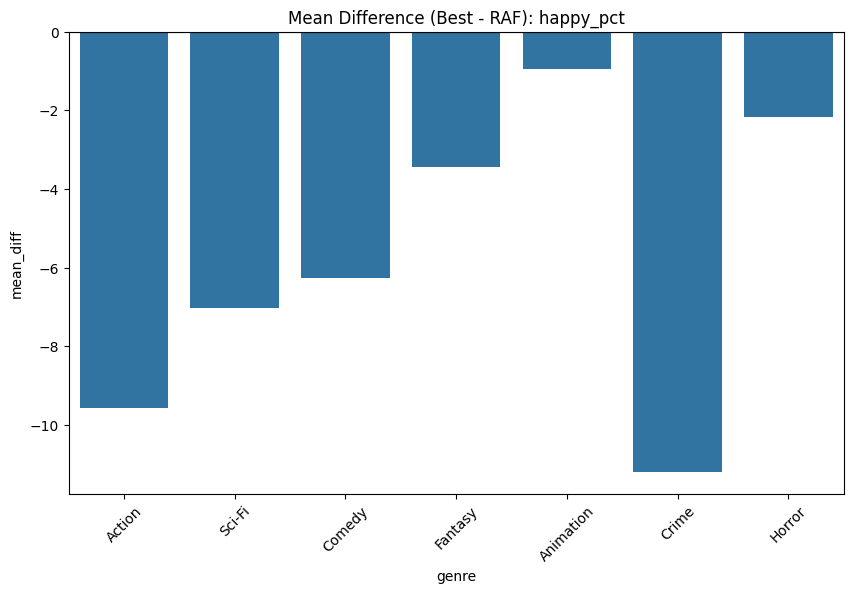

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

emotion = "happy_pct"

plot_df = results_df[results_df.emotion == emotion]

plt.figure(figsize=(10,6))
sns.barplot(
    data=plot_df,
    x="genre",
    y="mean_diff"
)

plt.axhline(0, color="black")
plt.title(f"Mean Difference (Best - RAF): {emotion}")
plt.xticks(rotation=45)
plt.show()


In [14]:
print(results_df.to_markdown())

|    | genre     | emotion      |   n |   mean_diff |   cohens_d |           t_p |   wilcoxon_p |    ci_low |   ci_high |       p_adj |
|---:|:----------|:-------------|----:|------------:|-----------:|--------------:|-------------:|----------:|----------:|------------:|
|  0 | Action    | angry_pct    |  17 |   28.7851   |   4.64374  |   1.87236e-12 |  1.52588e-05 |  25.992   |  31.6803  | 0.000178019 |
|  1 | Action    | fear_pct     |  17 |   14.0197   |   2.0559   |   2.59636e-07 |  1.52588e-05 |  10.953   |  17.286   | 0.000178019 |
|  2 | Action    | happy_pct    |  17 |   -9.56655  |  -1.58625  |   6.80534e-06 |  0.000643041 | -12.3409  |  -6.65044 | 0.00427246  |
|  3 | Action    | sad_pct      |  17 |  -14.5816   |  -1.96973  |   4.55876e-07 |  3.05176e-05 | -18.0892  | -11.2896  | 0.000267029 |
|  4 | Action    | surprise_pct |  17 |  -18.6566   |  -2.76519  |   4.3037e-09  |  1.52588e-05 | -21.7078  | -15.3649  | 0.000178019 |
|  5 | Sci-Fi    | angry_pct    |   7 |   30.400

In [15]:
results_df

,genre,emotion,n,mean_diff,cohens_d,t_p,wilcoxon_p,ci_low,ci_high,p_adj
0,Action,angry_pct,17,28.785130,4.643739,1.872358e-12,0.000015,25.991956,31.680252,0.000178
1,Action,fear_pct,17,14.019657,2.055904,2.596361e-07,0.000015,10.952964,17.285952,0.000178
2,Action,happy_pct,17,-9.566551,-1.586254,6.805344e-06,0.000643,-12.340904,-6.650442,0.004272
3,Action,sad_pct,17,-14.581601,-1.969726,4.558760e-07,0.000031,-18.089161,-11.289637,0.000267
4,Action,surprise_pct,17,-18.656635,-2.765186,4.303703e-09,0.000015,-21.707778,-15.364907,0.000178
5,Sci-Fi,angry_pct,7,30.400272,3.589205,7.771860e-05,0.015625,25.247257,36.840249,0.026042
6,Sci-Fi,fear_pct,7,10.168835,1.148996,2.280411e-02,0.015625,4.457251,16.327274,0.026042
7,Sci-Fi,happy_pct,7,-7.042496,-1.902052,2.374764e-03,0.015625,-9.579458,-4.401331,0.026042
8,Sci-Fi,sad_pct,7,-9.235174,-0.828794,7.080270e-02,0.078125,-16.843891,-1.198719,0.094289
9,Sci-Fi,surprise_pct,7,-24.291437,-6.807586,1.884315e-06,0.015625,-26.174560,-21.512930,0.026042


In [16]:
results_df.to_csv('ttest_results.csv')

In [17]:
results_df['genre'].unique()

array(['Action', 'Sci-Fi', 'Comedy', 'Fantasy', 'Animation', 'Crime',
       'Horror'], dtype=object)